In [31]:
from pricing import BlackScholesPricer, TrinomialTree, Market, Option
from pricing.convergence import *
import datetime as dt
import sys
# limite de récursion modifée
sys.setrecursionlimit(100000)

# parametrage de l'arbre
market = Market(S0=100, r=0.05, sigma=0.3, dividend=3, dividend_date=dt.date(2026, 9, 1))
option = Option(K=102, option_type="call", maturity=dt.date(2026, 9, 1), option_class="american")
tree = TrinomialTree(market, N=400, pruning=True, epsilon=1e-17, pricingDate=dt.date(2025, 9, 1))

# prix de l'arbre
price = tree.price(option, compute_greeks=False, activate_timer=True)
print("Prix de l’option:", price)

# black Scholes
bs = BlackScholesPricer(S=market.S0, K=option.K, T=tree.delta_t * tree.N, r=market.r, sigma=market.sigma, option_type='call', dividend=market.dividend, dividend_date = market.dividend_date)
bs_price = bs.price()
print(f"Black-Scholes Price: {bs_price}")

# graphique de l'arbre
# tree.plot_tree(tree.N)


[Timer] Pricing exécuté en 0.2145 secondes.
Prix de l’option: 13.27067736299091
Black-Scholes Price: 11.624734983743693


c'est tous des call avec vol de 30% et taux à 5%.
Prix de l’option: 13.27067736299091--> exercice=us, k=102, du 1/9/2025 au 1/9/2026, div=3, date div = 1/9/2026, n=400, prix du prof = 13.270677

Prix de l’option: 11.631179875040003--> exercice=eu, k=102, du 1/9/2025 au 1/9/2026, div=3, date div = 31/8/2026, n=400, prix du prof = 11.970834


Prix de l’option: 11.548101694370423--> exercice=us, k=102, du 1/9/2025 au 1/9/2026, div=3, date div = 2/9/2025, n=400, prix du prof = 11.550111

Prix de l’option: 11.547897764584805--> exercice=us, S0=97, k=102, du 1/9/2025 au 1/9/2026, pas de div, n=400, prix du prof = 11.547900

Prix de l’option: 11.748089126801288--> exercice=us, k=102, du 1/9/2025 au 1/9/2026, div=3, date div=21/4/2026, n=25, prix du prof = 11.797736

Prix de l’option: 11.903087433302034--> exercice=us, k=102, du 1/9/2025 au 1/9/2026, div=3, date div=21/4/2026, n=400, prix du prof = 11.936849

Prix de l’option: 11.971434446792475 --> exercice=eu, k=105, du 1/9/2025 au 1/9/2026, pas de div, n=400, prix du prof = 11.971454

In [2]:
# parametrage de l'arbre
market = Market(S0=100, r=0.05, sigma=0.3, dividend=3, dividend_date=dt.date.today() + dt.timedelta(days=92))
option = Option(K=110, option_type="call", maturity=dt.date.today() + dt.timedelta(days=200), option_class="european")
tree = TrinomialTree(market, N=600, pruning=True, epsilon=1e-7, pricingDate=dt.date.today())

# prix de l'arbre
price = tree.price(option, compute_greeks=False, activate_timer=True)
print("Prix de l’option:", price, "div_step", tree._compute_div_step())


[Timer] Pricing exécuté en 0.2268 secondes.
Prix de l’option: 4.885086298597936 div_step 276


In [3]:
# parametrage de l'arbre
market = Market(S0=100, r=0.05, sigma=0.3, dividend=3, dividend_date=dt.date.today() + dt.timedelta(days=93))
option = Option(K=110, option_type="call", maturity=dt.date.today() + dt.timedelta(days=200), option_class="european")
tree = TrinomialTree(market, N=600, pruning=True, epsilon=1e-7, pricingDate=dt.date.today())

# prix de l'arbre
price = tree.price(option, compute_greeks=False, activate_timer=True)
print("Prix de l’option:", price, "div_step", tree._compute_div_step())


[Timer] Pricing exécuté en 0.3337 secondes.
Prix de l’option: 4.88524901197897 div_step 279


In [4]:
# parametrage de l'arbre
market = Market(S0=100, r=0.05, sigma=0.3, dividend=3, dividend_date=dt.date.today() + dt.timedelta(days=94))
option = Option(K=110, option_type="call", maturity=dt.date.today() + dt.timedelta(days=200), option_class="european")
tree = TrinomialTree(market, N=600, pruning=True, epsilon=1e-7, pricingDate=dt.date.today())

# prix de l'arbre
price = tree.price(option, compute_greeks=False, activate_timer=True)
print("Prix de l’option:", price, "div_step", tree._compute_div_step())


[Timer] Pricing exécuté en 0.2730 secondes.
Prix de l’option: 4.885412639495586 div_step 282


In [ ]:
x=[]
y=[]
for i in range(0, 150):
    # parametrage de l'arbre
    market = Market(S0=100, r=0.05, sigma=0.3, dividend=3, dividend_date=dt.date.today() + dt.timedelta(days=i))
    option = Option(K=110, option_type="call", maturity=dt.date.today() + dt.timedelta(days=150), option_class="european")
    tree = TrinomialTree(market, N=600, pruning=False, epsilon=1e-7, pricingDate=dt.date.today())

    # prix de l'arbre
    y.append(tree.price(option, compute_greeks=False, activate_timer=False))
    x.append(i)
    if y[-1] > 9.5:
        print(i, y[-1], tree._compute_div_step())

import pandas as pd
pd.DataFrame({
    'y': y
}).plot()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1063a9a00>>
Traceback (most recent call last):
  File "/Users/yves-mariesaliou/Documents/Cours/M2 IEF 272/INFO QUANT/PROJET/PRICER V1/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 797, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
PETITE FONCTION
ARCHITECTURE TYPE COMPTE EPARGN ETC (savoir architecturer)
PARTIE QCM

# Graphique de Convergence et d'Erreur

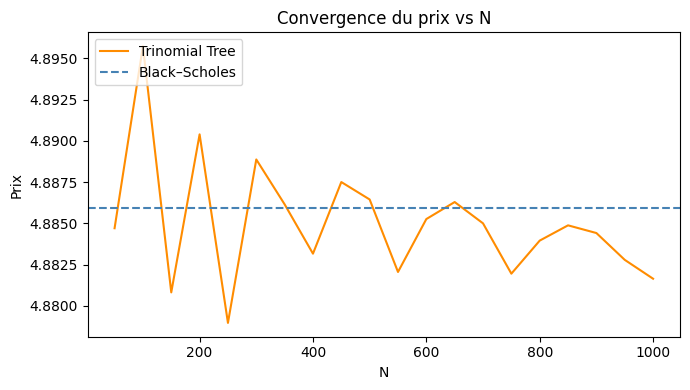

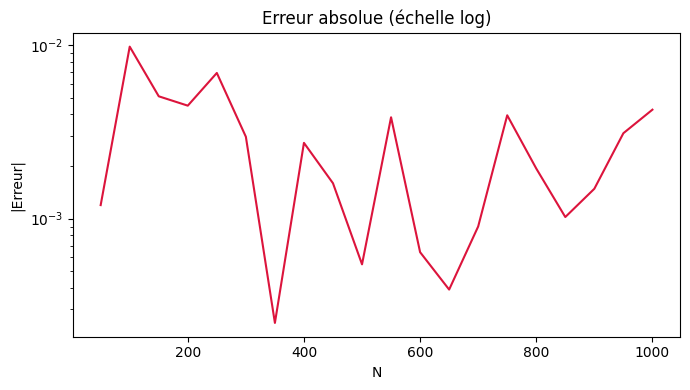

In [5]:
# bs_convergence_by_strike(market, option, strikes=range(80, 161, 3), n_steps=1000)
bs_convergence_by_step(market, option, max_n=1000, step=50, pruning=False)

# Grecques - Arbre Trinomial

In [ ]:
print(f"Delta : {tree.delta():.6f}")
print(f"Gamma : {tree.gamma():.6f}")
print(f"Vega  : {tree.vega(option):.6f}")   # déjà par 1% de vol
print(f"Vanna : {tree.vanna(option):.6f}")  # déjà par 1% de vol
print(f"Rho   : {tree.rho(option):.6f}")    # déjà par 1% de taux

RuntimeError: Activez compute_greeks dans price().

# Grecques - Black-Scholes

In [ ]:
bs.greeks()

{'delta': 0.4134466041141795,
 'gamma': 0.019265804746051423,
 'theta': -0.013510812713292021,
 'vega': 0.3937613791932702,
 'rho': 0.36730645004174056,
 'vanna': 0.00819673312412271}

In [ ]:
# soutenance sur teams de 30 min
# 2 quizz jusqu'à 17h le 29/10 : un qualitatif -> questions et un quantitatif où on va 
# devoir utiliser notre code pour répondre (possible de faire un ajout de code aussi)
# exemple qualitatif : quelle est le plus gros reproche de l'abre trinomial
# le qualitatif c'est 20 questions en 20 minutes sans retour parfois choix multiples (plus qu'une réponse 
# à chaque questions à choix multiples)
# les calculs sont que des calculs faisables de test
# le qcm quantitatif n'est pas limité dans le temps (pricing d'options, du delta hedge, calcul de vega)
# toujours saisi sans retour

delta: prix_option en S0+epsilon (dans le temps) + prix_option en S0-epsilon/ 2*epsilon
c'est au QCM ça.
Les risk managers font des delta en pourcentage de la valeur du produit pour avoir des calls en % pour pouvoir comparer des produits similaires. Le epsilon est par exemple 1% de la valeur du produit. epsilon = 0.4 pour un produit à 40 et 4 pour un produit à 400 (décalage d'1%)
Il faudra utiliser la première méthode pour le QCM.

Gamma: dérivé du delta donc --> delta+ - delta- si unité de 1 de décalage
Avec un epsilon : (delta+(de epsilon) - delta-)/epsilon
à partir du prix = (Prixoption(S0 + epsilon) + Prixoption(S0-epsilon) - 2*Prixoption(S0)) / epsilon^2

Vega : (dérivé du prix par sigma) * 1%
 = (PrixS0 + 1% - PrixS0 - 1%)/2 car c'est de la vol

vega = dérivé seconde par rapport à la vol

vanna = dérivé croisée = dérivé du vega par rapport au spot = dérivée du delta par rapport à la vol


dérivée dans le code:
le callable est une fonction qui doit prendre un float en argument (valeur par rapport à laquelle on dérive)
shift = amplituyde de la variation

In [ ]:
# partir de la fin de l'arbre et casser les liens en les mettant = None
# , pas oublier de casser les liens du noeud vers l'arbre
# ça c'est pour VBA (avec compteur du nombre de noeud).
# pour python pareil